In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import interpolate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def integral(Y1,Y2,E1,E2):
    INT=(Y2*E2-Y1*E1)/((np.log(Y2/Y1)/np.log(E2/E1)+1))
    #print(E1,E2,INT)
    return INT

def load_obj(name):
    with open('C:\\Users\\ginti\\Desktop\\nirs\\' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def Y_NM_Mi20_a(energy,h):
    P=np.sqrt(energy*energy+2*0.938*energy)
    X=np.log(P)
    if energy<1.7:
        a,b,c,d=0.5082, -3.0659, 7.2827, -9.5396
    #if energy<1.6:
    #    a,b,c,d=2.0404,	-8.1776,	12.354,	-11.1
    elif (energy>=1.7 and energy<15):
        a,b,c,d=0.1179,	-1.2022,	4.9329,	-8.65
    else:
        a,b,c,d=0,	-0.0365,	1.206,	-4.763
    LnY1000=a*X*X*X+b*X*X+c*X+d
    Y1000=np.exp(LnY1000)
    A = 9.422E-09*np.power(X,5) - 2.284E-07*np.power(X,4) + 2.037E-06*np.power(X,3) - 7.828E-06*np.power(X,2) + 1.203E-05*np.power(X,1) - 5.545E-06					
    B = -5.351E-06*np.power(X,5) + 1.316E-04*np.power(X,4) - 1.226E-03*np.power(X,3) + 5.176E-03*np.power(X,2) - 1.017E-02*np.power(X,1) + 1.458E-02				
    alt_dep=(1000-h)*(1000-h)*A+(1000-h)*B
    Y=Y1000*np.exp(alt_dep)
    return Y

def Y_NM_Mi20_p(energy, h):
    P=np.sqrt(energy*energy+2*0.938*energy)
    X=np.log(P)
    #if energy<1.25:
    #    a,b,c,d=6.09,	-14.06,	13.98,	-11.615
    if energy<1.28:
        a,b,c,d=0,	-8.6616,	13.879,	-12.104
    elif energy >=1.28 and energy<10:
        a,b,c,d=-0.186,	0.428,	2.831,	-8.76
    else:
        a,b,c,d=0,	-0.0365,	1.206,	-4.763
    LnY1000=a*X*X*X+b*X*X+c*X+d
    Y1000=np.exp(LnY1000)
    A= 6.945E-09*np.power(X,5) - 1.461E-07*np.power(X,4) + 1.115E-06*np.power(X,3) - 3.402E-06*np.power(X,2) + 3.355E-06*np.power(X,1) - 9.823E-07
    B= -3.963E-06*np.power(X,5) + 8.091E-05*np.power(X,4) - 6.394E-04*np.power(X,3) + 2.348E-03*np.power(X,2) - 4.713E-03*np.power(X,1) + 1.186E-02
    alt_dep=(1000-h)*(1000-h)*A+(1000-h)*B
    Y=Y1000*np.exp(alt_dep)
    return Y

In [2]:
def hepams(ener):
    
    data_protons = load_obj('AMS_spec_p')
    data_he = load_obj('AMS_spec_he')

    newprot = []

    for k in data_protons:
        x = np.log10(data_protons[k][0])
        y = np.log10(data_protons[k][2])
        f = interpolate.interp1d(x, y, fill_value="extrapolate")

        xnew = np.log10(data_he[k][0])
        ynew=f(xnew)

        newprot.append(10**ynew)

    l = 0
    hep = []
    meh = []

    for i in data_he:
        a = (float(data_he[i].iloc[[ener], [2]].values))/float(newprot[l][ener])
        hep.append(a)                
        l+=1
        
    return hep

In [3]:
def heppam(ener):
    
    data_protons = load_obj('p_PAM_CR')
    data_he = load_obj('a_PAM_CR')

    newprot = []

    for k in data_protons:
        x = np.log10(data_protons[k][0])
        y = np.log10(data_protons[k][2])
        f = interpolate.interp1d(x, y, fill_value="extrapolate")

        xnew = np.log10(data_he[k][0])
        ynew=f(xnew)

        newprot.append(10**ynew)

    l = 0
    hep = []
    meh = []

    for i in data_he:
        a = (float(data_he[i].iloc[[ener], [2]].values))/float(newprot[l][ener])
        hep.append(a)                
        l+=1
        
    return hep

In [21]:
def sumpam(pc,depth):
    
    tt = depth
    
    data_protons = load_obj('p_PAM_CR')
    data_he = load_obj('a_PAM_CR')
    
    al = []
    s1 = 0
    
    for j in data_protons:
        for k in range(0,98):
            if float(data_protons[j].iloc[[k], [0]].values) > pc:            
                a = float(data_protons[j].iloc[[k], [4]].values)
                b = Y_NM_Mi20_p(a,tt) * float(data_protons[j].iloc[[k], [6]].values)
                c = float(data_protons[j].iloc[[k+1], [4]].values)
                d = Y_NM_Mi20_p(c,tt) * float(data_protons[j].iloc[[k+1], [6]].values)
                s1 += integral(b, d, a, c)
        al.append(s1)
        s1 = 0
        
    s2 = 0
    an = []
    
    iheavy = open('C:\\Users\\ginti\\Desktop\\nirs\\heavyp.txt','r')
    linesiheavy = iheavy.readlines()
    heavy = []
    for x in linesiheavy:
        heavy.append(x.split()[0])
    iheavy.close()
    
    for j in data_he:
        for k in range(0,49):        
            if float(data_he[j].iloc[[k], [0]].values) > pc:
                a = float(data_he[j].iloc[[k], [4]].values)
                b = Y_NM_Mi20_a(a,tt) * float(data_he[j].iloc[[k], [6]].values) * (1 + float(heavy[k]))
                c = float(data_he[j].iloc[[k+1], [4]].values)
                d = Y_NM_Mi20_a(c,tt) * float(data_he[j].iloc[[k+1], [6]].values)  * (1 + float(heavy[k+1]))
                s2 += integral(b, d, a, c)
        an.append(4*s2)
        s2 = 0
    nn = []
    
    for i in range(len(an)):
        phe = al[i] + an[i]
        nn.append(phe)
        
    return nn

In [30]:
def sumams(pc,depth):
    
    tt = depth
    
    data_protons = load_obj('AMS_spec_p')
    data_he = load_obj('AMS_spec_he')
    
    al = []
    s1 = 0
    
    for j in data_protons:
        for k in range(0,71):
            if float(data_protons[j].iloc[[k], [0]].values) > pc:            
                a = float(data_protons[j].iloc[[k], [4]].values)
                b = Y_NM_Mi20_p(a,tt) * float(data_protons[j].iloc[[k], [6]].values)
                c = float(data_protons[j].iloc[[k+1], [4]].values)
                d = Y_NM_Mi20_p(c,tt) * float(data_protons[j].iloc[[k+1], [6]].values)
                s1 += integral(b, d, a, c)
        al.append(s1)
        s1 = 0
        
    s2 = 0
    an = []
    
    iheavy = open('C:\\Users\\ginti\\Desktop\\nirs\\heavy.txt','r')
    linesiheavy = iheavy.readlines()
    heavy = []
    for x in linesiheavy:
        heavy.append(x.split()[1])
    iheavy.close()
    
    for j in data_he:
        for k in range(0,66):        
            if float(data_he[j].iloc[[k], [0]].values) > pc:
                a = float(data_he[j].iloc[[k], [4]].values)
                b = Y_NM_Mi20_a(a,tt) * float(data_he[j].iloc[[k], [6]].values) * (1 + float(heavy[k]))
                c = float(data_he[j].iloc[[k+1], [4]].values)
                d = Y_NM_Mi20_a(c,tt) * float(data_he[j].iloc[[k+1], [6]].values)  * (1 + float(heavy[k+1]))
                s2 += integral(b, d, a, c)
        an.append(4*s2)
        s2 = 0
    nn = []
    
    for i in range(len(an)):
        phe = al[i] + an[i]
        nn.append(phe)
        
    return nn

In [31]:
time = load_obj('AMS_time')
tams = [float(time.iloc[[j], [2]].values) for j in range(0,79)]
    
time = load_obj('time_PAM_CR')
tpam = [float(time.iloc[[j], [2]].values) for j in range(0,51)]

In [32]:
pam57 = sumpam(6.90668,886.94)
pam010 = sumpam(0,1025.07)
ams57 = sumams(6.90668,886.94)
ams010 = sumams(0,1025.07)

Text(0, 0.5, '$NM_{1}/NM_{2}$')

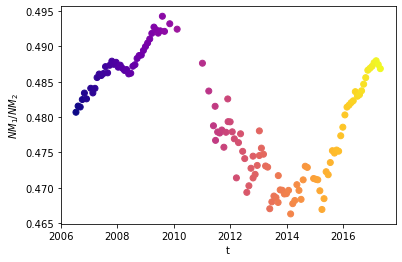

In [33]:
npam=[pam010[i]/pam57[i] for i in range(len(pam57))]
nams=[ams010[i]/ams57[i] for i in range(len(ams57))]
t = tpam+tams
nnn = npam+nams
fig = plt.figure()
plt.scatter(t, nnn, c=t, cmap="plasma")
plt.xlabel('t')
plt.ylabel('$NM_{1}/NM_{2}$')

In [34]:
data_hepam = load_obj('a_PAM_CR')
data_heams = load_obj('AMS_spec_he')

In [35]:
hepp = [heppam(k) for k in range(len(data_hepam[2049]))]
hepa = [hepams(k) for k in range(len(data_heams[2426]))]

In [36]:
corrpam = []
for k in hepp:
    x = np.array(k).reshape((-1, 1))
    y = np.array(npam)
    model = LinearRegression().fit(x, y)

    x_train = x.reshape(-1, 1)
    x_test = x.reshape(-1, 1)
    y_pred = model.predict(x_test)
    coefficient_of_dermination2 = r2_score(y, y_pred)
    corrpam.append(coefficient_of_dermination2)

corrams = []
for k in hepa:
    x = np.array(k).reshape((-1, 1))
    y = np.array(nams)
    model = LinearRegression().fit(x, y)

    x_train = x.reshape(-1, 1)
    x_test = x.reshape(-1, 1)
    y_pred = model.predict(x_test)
    coefficient_of_dermination2 = r2_score(y, y_pred)
    corrams.append(coefficient_of_dermination2)

Text(0, 0.5, 'Corr')

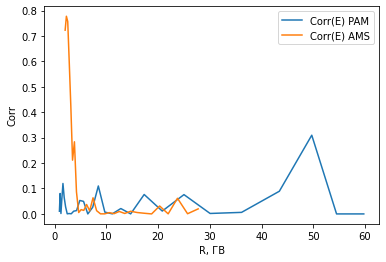

In [37]:
cogpam = data_hepam[2045][0]
cogams = data_heams[2426][0]

fig, ax = plt.subplots()
ax.plot(cogpam[:30], corrpam[:30])
ax.plot(cogams[:30], corrams[:30])

ax.legend(["Corr(E) PAM", "Corr(E) AMS"])
ax.set_xlabel("R, ГВ")
ax.set_ylabel("Corr")